# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import cv2
import pickle
import datetime
import time
import random
import collections

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import multiprocessing as mp
from sklearn.model_selection import train_test_split

# load and pre-process data by subtracting channel mean from each image

In [5]:

NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

#root_dir = 'food-101/images/'

# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# shuffles the array
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        #print(noodle_class,label)
        #input('wait1')
        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
            if img.startswith('.'): # .DS_Store
                continue
            # each image is a 2D array of RGB value
            try:
                img_arr = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_arr, (227, 227))
                new_img = new_img.astype('float32')
                per_channel_mean = np.mean(new_img, axis=(0))
                new_img = np.subtract(per_channel_mean,new_img) #i want this cause cv2 inverted
                
                #plt.imshow(resized_img)
                #plt.show()

                features.append(new_img)
                labels.append(label) # shove (X,y) in here cause we wanna shuffle 
                #print(data_set)
            except Exception as e:
                print("create exception: ",e,"on",img)

        

    X = np.array(features).reshape(-1, 227, 227, 3)
    y = np.array(labels).reshape(-1, 1)
    X = X.astype('float32')
    #save(X,y,_name)
    
    return X,y


# function to prepare the test data for model evaluation

In [6]:
def prepare_test_data():
    data_set = []
    test_dir = '/Users/flo/Desktop/456/_SEMESTER_PROJECT/food-101/test' 
    features = []
    labels = []
    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(test_dir, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        print(noodle_class,label)
        #input('wait1')

        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
                if img.startswith('.'): # .DS_Store
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img))
                    #img_to_rgb = img_arr[:,:,::-1] 
                    new_img = cv2.resize(img_arr,(227,227)) 

                    features.append(new_img) # shove (X,y) in here cause we wanna shuffle 
                    labels.append(label)
                except Exception as e:
                    print("create exception: ",e)
        
    X = np.array(features).reshape(-1, 227, 227, 3) # -1 = any number of features (catch-all, it'll recognize)
    y = np.array(labels).reshape(-1, 1)

    return X,y

# create data, normalize x and y

In [7]:
X_train, y_train = create_data('food-101/train', "train")
X_valid, y_valid = create_data('food-101/valid',"valid")

X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

X_test, y_test = prepare_test_data()
X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4


# iteration 32

In [8]:
# move drop out 
# epochs 30

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 36
learn_rate = 0.001
epochs = 40
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.3)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .0005
    else:
        return .00005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[checkpointer,lr_scheduler])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  13:38:45
Epoch 1/40
116/117 [============================>.] - ETA: 1s - loss: 1.5639 - accuracy: 0.2873
Epoch 00001: val_loss improved from inf to 1.59446, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/36-32-bsz-0.001-lr-40-ep.01-1.59.hdf5
117/117 [==============================] - 135s 1s/step - loss: 1.5624 - accuracy: 0.2878 - val_loss: 1.5945 - val_accuracy: 0.2002
Epoch 2/40
116/117 [============================>.] - ETA: 0s - loss: 1.3751 - accuracy: 0.4148
Epoch 00002: val_loss improved from 1.59446 to 1.50502, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/36-32-bsz-0.001-lr-40-ep.02-1.51.hdf5
117/117 [==============================] - 131s 1s/step - loss: 1.3742 - accuracy: 0.4150 - val_loss: 1.5050 - val_accuracy: 0.314

117/117 [==============================] - 133s 1s/step - loss: 0.6664 - accuracy: 0.7507 - val_loss: 0.6941 - val_accuracy: 0.7303
Epoch 24/40
116/117 [============================>.] - ETA: 1s - loss: 0.6742 - accuracy: 0.7491
Epoch 00024: val_loss did not improve from 0.69408
117/117 [==============================] - 133s 1s/step - loss: 0.6744 - accuracy: 0.7485 - val_loss: 0.7051 - val_accuracy: 0.7338
Epoch 25/40
116/117 [============================>.] - ETA: 1s - loss: 0.6485 - accuracy: 0.7607
Epoch 00025: val_loss did not improve from 0.69408
117/117 [==============================] - 134s 1s/step - loss: 0.6471 - accuracy: 0.7614 - val_loss: 0.7068 - val_accuracy: 0.7280
Epoch 26/40
116/117 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.7488
Epoch 00026: val_loss did not improve from 0.69408
117/117 [==============================] - 130s 1s/step - loss: 0.6629 - accuracy: 0.7488 - val_loss: 0.7152 - val_accuracy: 0.7269
Epoch 27/40
116/117 [=======

# evaluate model on validation data

In [9]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/36.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

# test_scores = model.predict_generator(test_generator, verbose=2)
# print('Test loss:', test_scores[0])
# print('test accuracy:', test_scores[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0

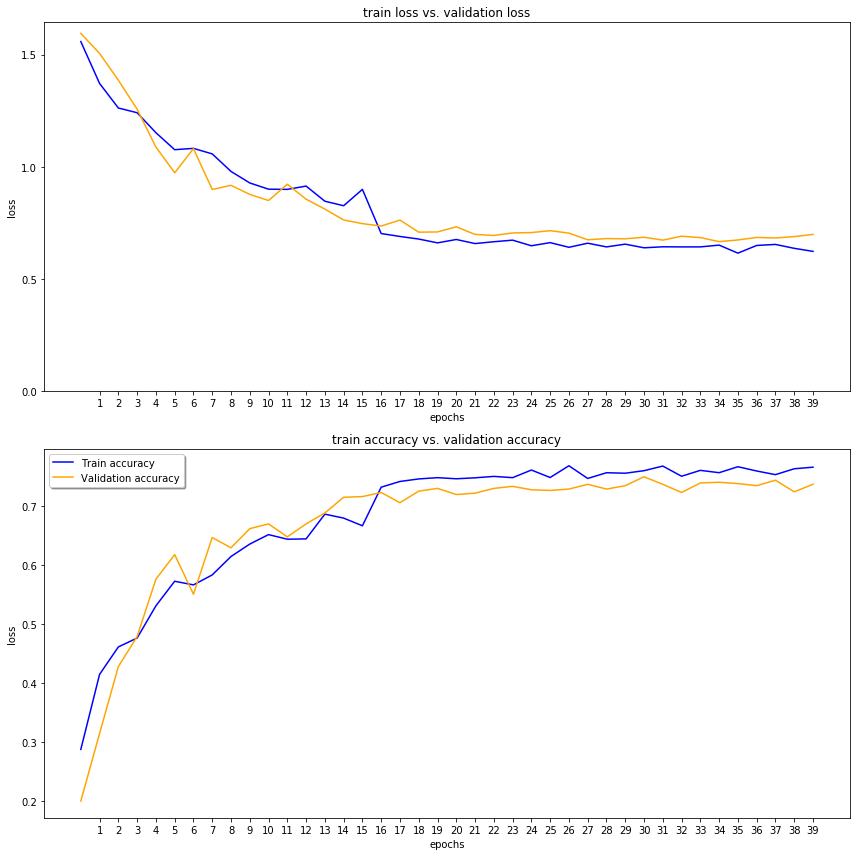

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 33

In [11]:
# raise drop out to .4
# raise learning rates

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 26
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 25:
        return .001
    else:
        return .0005
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  15:19:34
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5619 - accuracy: 0.2930
Epoch 00001: val_loss improved from inf to 1.58876, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.01-1.59.hdf5
117/117 [==============================] - 140s 1s/step - loss: 1.5615 - accuracy: 0.2932 - val_loss: 1.5888 - val_accuracy: 0.2477
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.3569 - accuracy: 0.4230
Epoch 00002: val_loss improved from 1.58876 to 1.49897, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.02-1.50.hdf5
117/117 [==============================] - 133s 1s/step - loss: 1.3554 - accuracy: 0.4236 - val_loss: 1.4990 - val_accuracy: 0.3345


Epoch 24/30
116/117 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.7724
Epoch 00024: val_loss did not improve from 0.64123
117/117 [==============================] - 133s 1s/step - loss: 0.6073 - accuracy: 0.7719 - val_loss: 0.6519 - val_accuracy: 0.7454
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6137 - accuracy: 0.7751
Epoch 00025: val_loss improved from 0.64123 to 0.63497, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.25-0.63.hdf5
117/117 [==============================] - 148s 1s/step - loss: 0.6120 - accuracy: 0.7757 - val_loss: 0.6350 - val_accuracy: 0.7801
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.5817 - accuracy: 0.7849
Epoch 00026: val_loss improved from 0.63497 to 0.63353, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.26-0.63.hdf5
117/117 [==============================] - 142s 1s/step - loss: 0.5822

# graph

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_6 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_7 (Activation)    (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)      

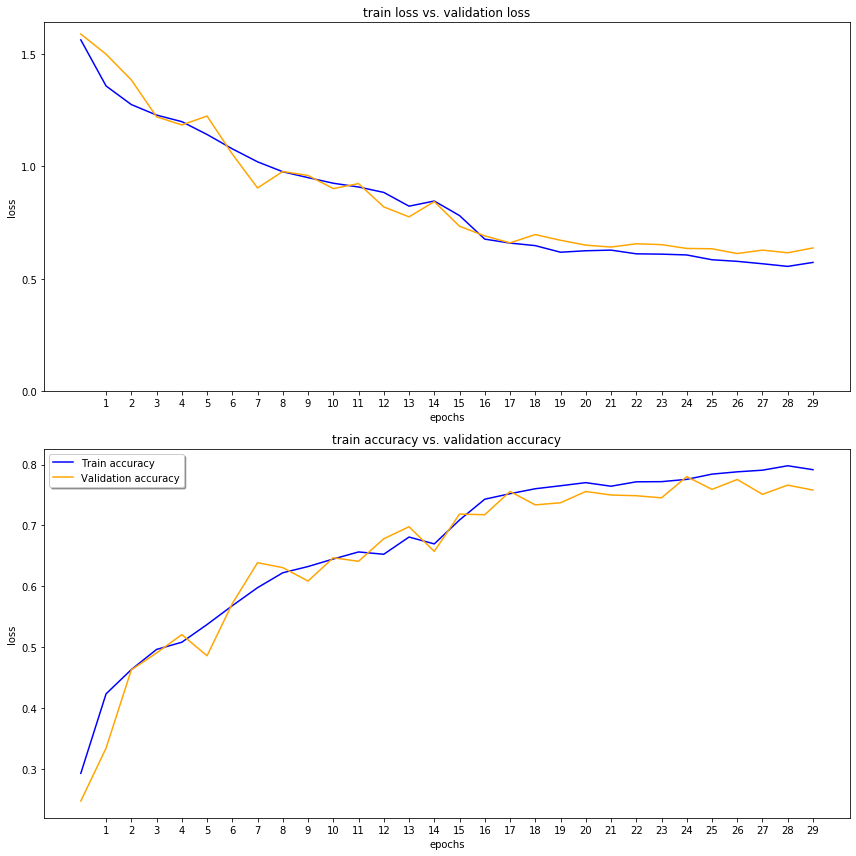

In [12]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/37.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


# iteration 34 (best model)

In [14]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 26
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  17:10:23
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5634 - accuracy: 0.2816
Epoch 00001: val_loss improved from inf to 1.58435, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.01-1.58.hdf5
117/117 [==============================] - 137s 1s/step - loss: 1.5626 - accuracy: 0.2824 - val_loss: 1.5844 - val_accuracy: 0.2593
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.4011 - accuracy: 0.3880
Epoch 00002: val_loss improved from 1.58435 to 1.54810, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.02-1.55.hdf5
117/117 [==============================] - 135s 1s/step - loss: 1.4010 - accuracy: 0.3881 - val_loss: 1.5481 - val_accuracy: 0.2627


117/117 [==============================] - 145s 1s/step - loss: 0.6071 - accuracy: 0.7767 - val_loss: 0.6467 - val_accuracy: 0.7581
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6233 - accuracy: 0.7727
Epoch 00025: val_loss did not improve from 0.64672
117/117 [==============================] - 136s 1s/step - loss: 0.6221 - accuracy: 0.7736 - val_loss: 0.6518 - val_accuracy: 0.7569
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.5921 - accuracy: 0.7707
Epoch 00026: val_loss did not improve from 0.64672
117/117 [==============================] - 135s 1s/step - loss: 0.5913 - accuracy: 0.7714 - val_loss: 0.6552 - val_accuracy: 0.7407
Epoch 27/30
116/117 [============================>.] - ETA: 1s - loss: 0.5975 - accuracy: 0.7756
Epoch 00027: val_loss improved from 0.64672 to 0.64020, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/26-32-bsz-0.01-lr-30-ep.27-0.64.hdf5
117/117 [==============================] - 134s 1

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_18 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_19 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 256)      

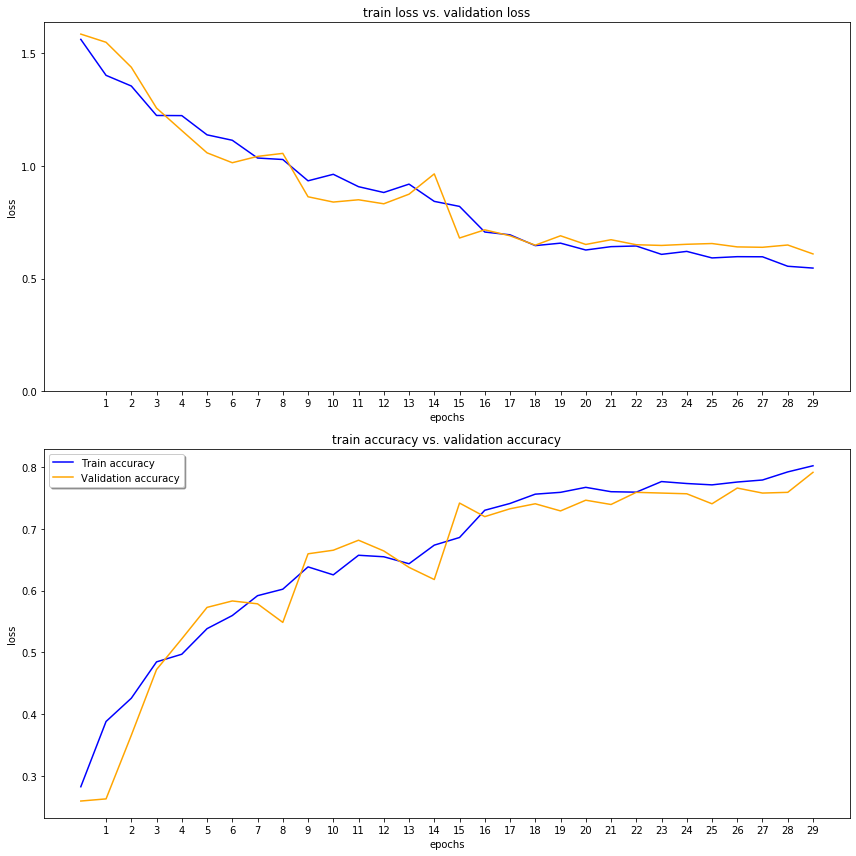

In [15]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/38.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 35

In [16]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 39
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.25)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 30:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  18:24:22
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5554 - accuracy: 0.2805
Epoch 00001: val_loss improved from inf to 1.55571, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/39-32-bsz-0.01-lr-30-ep.01-1.56.hdf5
117/117 [==============================] - 144s 1s/step - loss: 1.5529 - accuracy: 0.2813 - val_loss: 1.5557 - val_accuracy: 0.3611
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.3751 - accuracy: 0.3985
Epoch 00002: val_loss improved from 1.55571 to 1.44978, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/39-32-bsz-0.01-lr-30-ep.02-1.45.hdf5
117/117 [==============================] - 138s 1s/step - loss: 1.3718 - accuracy: 0.3997 - val_loss: 1.4498 - val_accuracy: 0.4236


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_24 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_25 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 256)      

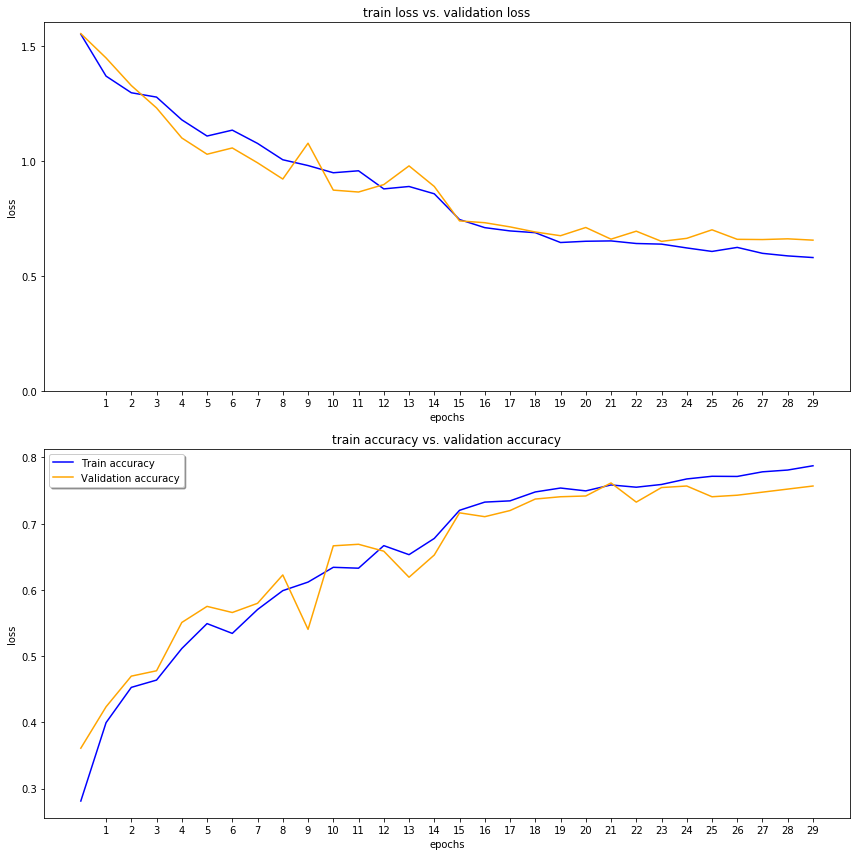

In [17]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/37.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# iteration 36

In [18]:
print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)


_iter = 39
learn_rate = 0.01
epochs = 30
batch_size=32

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

#log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# #layer 3: Conv3 + Relu
# model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 4: Conv4 + Relu
# model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
# model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC6 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.3)) #bad to add drop out right before the last layer?

# layer 7: FC7 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))

# layer 8: FC8 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))


# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

def schedule(epoch):
    if epoch < 20:
        return .01
    elif epoch < 25:
        return .005
    else:
        return .0001
lr_scheduler = LearningRateScheduler(schedule)

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size,shuffle=True)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size,shuffle=True)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit_generator(train_generator,
                           validation_data=valid_generator,
                           epochs=epochs,      # epochs = how many times go through the network
                           steps_per_epoch=X_train.shape[0]//batch_size, # number of batch iterations before an epoch is finished
                           validation_steps=X_valid.shape[0]//batch_size,
                           shuffle=True,
                           callbacks=[lr_scheduler,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

X after normal [-0.02995581 -0.01778729 -0.01882338]
y after normal [1. 0. 0. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
Training start  19:38:39
Epoch 1/30
116/117 [============================>.] - ETA: 1s - loss: 1.5589 - accuracy: 0.2873
Epoch 00001: val_loss improved from inf to 1.58410, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/39-32-bsz-0.01-lr-30-ep.01-1.58.hdf5
117/117 [==============================] - 141s 1s/step - loss: 1.5573 - accuracy: 0.2881 - val_loss: 1.5841 - val_accuracy: 0.3125
Epoch 2/30
116/117 [============================>.] - ETA: 1s - loss: 1.4440 - accuracy: 0.3622
Epoch 00002: val_loss improved from 1.58410 to 1.53934, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/39-32-bsz-0.01-lr-30-ep.02-1.54.hdf5
117/117 [==============================] - 140s 1s/step - loss: 1.4422 - accuracy: 0.3634 - val_loss: 1.5393 - val_accuracy: 0.3310


Epoch 24/30
116/117 [============================>.] - ETA: 1s - loss: 0.6559 - accuracy: 0.7558
Epoch 00024: val_loss improved from 0.71421 to 0.68498, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/39-32-bsz-0.01-lr-30-ep.24-0.68.hdf5
117/117 [==============================] - 140s 1s/step - loss: 0.6571 - accuracy: 0.7547 - val_loss: 0.6850 - val_accuracy: 0.7303
Epoch 25/30
116/117 [============================>.] - ETA: 1s - loss: 0.6387 - accuracy: 0.7585
Epoch 00025: val_loss did not improve from 0.68498
117/117 [==============================] - 147s 1s/step - loss: 0.6408 - accuracy: 0.7574 - val_loss: 0.7718 - val_accuracy: 0.7176
Epoch 26/30
116/117 [============================>.] - ETA: 1s - loss: 0.6920 - accuracy: 0.7396
Epoch 00026: val_loss did not improve from 0.68498
117/117 [==============================] - 147s 1s/step - loss: 0.6901 - accuracy: 0.7405 - val_loss: 0.6975 - val_accuracy: 0.7222
Epoch 27/30
116/117 [============================

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_30 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_31 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 256)      

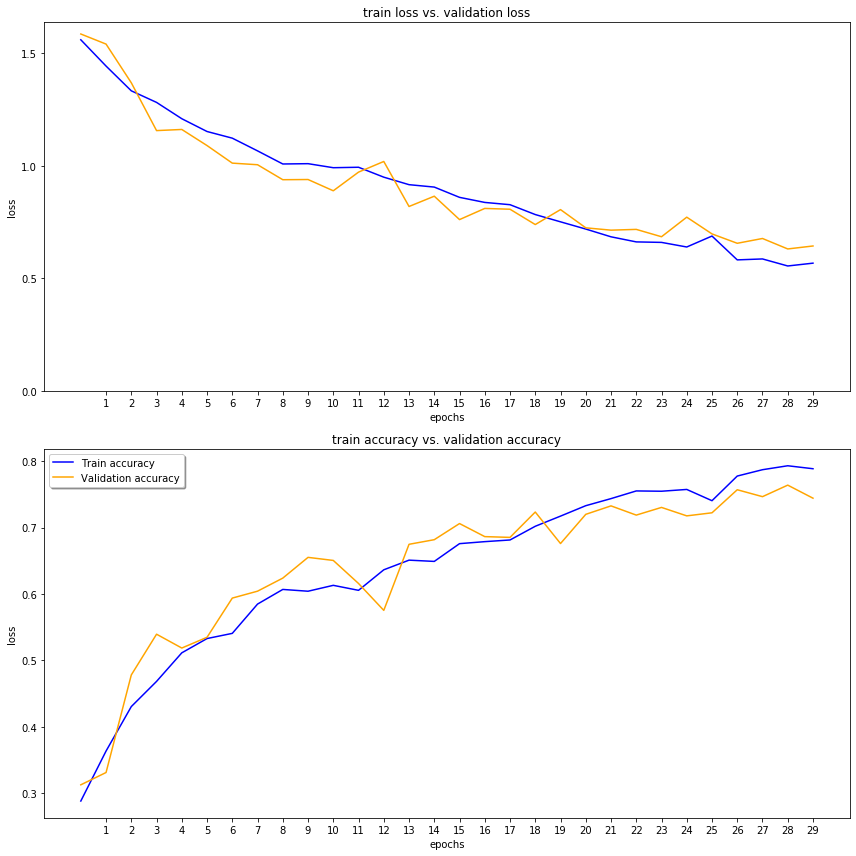

In [19]:
model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/38.h5')
model.summary()

scores = model.evaluate(X_valid, y_valid, verbose=2)
print('Valid loss:', scores[0])
print('Valid accuracy:', scores[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='#ffa500',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()